Zhiting Zhou 11/13/2023

In [4]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import networkx as nx

In [5]:
# variables
brown = 0
purple = 1

time_steps = 100
num_agents = 200
monte_carlo = 50
random_seed = 1

In [6]:
# individual agent's policy
def policy(states=None, func=None, impacted_by_portion=None, confidence=None, impact_from_others=[], cost_of_state=None):
    rt_value = 0 # assume the agent returns brown if no other condition speficied
    prob_purple = 0
    
    def f(x):
        if func != None:
            result = func(x)
        else: 
            result = math.pow(x, 4)
        return result
    
    if impacted_by_portion != None:
        portion_purple = sum(states) / len(states)
        prob_purple = f(portion_purple)
    
    if confidence != None:
        if confidence > 1 or confidence < 0:
            print('confidence level need to be between 0 and 1')
        else:
            prob_purple = (1-confidence) * prob_purple
        
    # if impact_from_others.shape != 0:
    #     if impact_from_others.shape[1] != len(states):
    #         print("the length of impact should equal to the length of states")
    #     # if sum(impact_from_others) > 1:
    #     #     print("impact factros too large")
    #     else:
    #         weighted_states = impact_from_others * states
    #         prob_purple = f(weighted_states)
            
    if cost_of_state != None:
        (state, cost) = cost_of_state # state is set to be purple for now
        prob_purple = (1-cost) * prob_purple
        
    prob_brown = 1 - prob_purple    
    
    p = random.uniform(0, 1)

    if p > prob_purple:
        rt_value = 0
    else:
        rt_value = 1

    return rt_value
        
    

In [7]:
def generate_states(num_agents, num_purple=None):
    if num_purple > num_agents: # Check if the input is valid
        return "m should not be greater than n"
    states = [1] * num_purple + [0] * (num_agents - num_purple)  # List with m zeros and (n-m) ones
    random.shuffle(states)
    return states


In [8]:
def linear(x):
    return x

In [9]:
def simulation(num_agents=1000, depends_on_past_states=True, past_states=None, 
               func=None, impacted_by_portion=None, confidence=None, impact_from_others=None, cost_of_state=None):
    current_states = np.copy(past_states)
    for i in range(num_agents):
        if past_states[i] == 1: # it is already purple
            # do nothing
            current_states[i] = past_states[i]
        else:
            if depends_on_past_states:
                states = past_states
            else:
                states = current_states
                
            states = np.multiply(impact_from_others[i], states)
            state = policy(states=states, func=func, impacted_by_portion=impacted_by_portion, confidence=confidence, cost_of_state=cost_of_state)
            current_states[i] = state
            
    current_purple = sum(current_states) # how many purple we end up with
    past_purple = sum(past_states)
    increased_purple = current_purple - past_purple
    return current_states, current_purple, increased_purple

In [10]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=100)
    plt.show()


In [11]:

labels = [str(i) for i in range(num_agents)]
adjacency_0 = np.array([[0 for _ in range(num_agents)] for _ in range(num_agents)])
adjacency_1 = np.array([[1 for _ in range(num_agents)] for _ in range(num_agents)])
adjacency_random = np.array([[random.randint(0, 1) for _ in range(num_agents)] for _ in range(num_agents)])
adjacency_identity = np.identity(num_agents)

# specify which adjacency matrix to use
adjacency = adjacency_1
# show_graph_with_labels(adjacency)

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

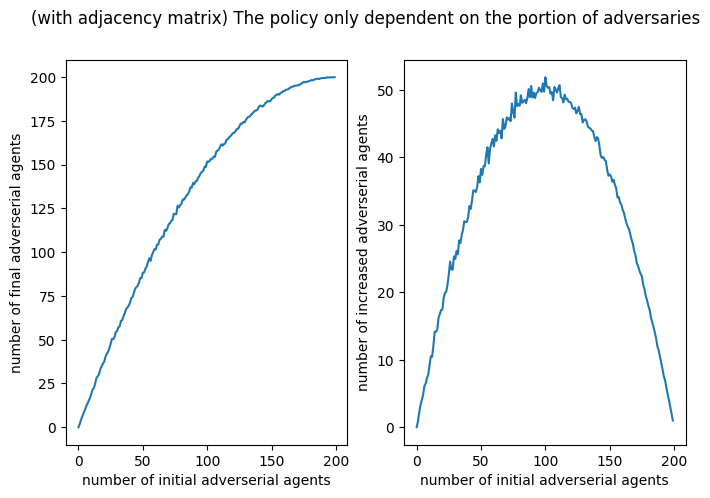

In [12]:
# single iteration simulation begins
random.seed(random_seed)
depends_on_past_states = True # if the agent's policy depends on past states or current states?
num_purple = [] # how many purple we end up with
nums = [] # keep track of how many initial purples we tested
num_portion = []
num_increase = []
for num_adv in range(num_agents):
    past_states = generate_states(num_agents=num_agents, num_purple=num_adv) # initial states: i purples, which means i adversaries
    
    # simulate for 10 times
    current_states_carlo = []
    current_purple_carlo = 0
    for iter in range(monte_carlo): 
        current_states, current_purple, increased_purple = simulation(num_agents=num_agents, depends_on_past_states=True,past_states=past_states,
                                                                      func=linear, impacted_by_portion=True, confidence=None, impact_from_others=adjacency, cost_of_state=None)
        if iter == 0:
            current_states_carlo =  np.copy(current_states)
        else:
            current_states_carlo = current_states_carlo + current_states
        current_states_carlo = np.array(current_states_carlo)
        current_purple_carlo += current_purple
        
    current_states = [round(num) for num in current_states_carlo/monte_carlo] # make sure the states are binary

    current_purple = current_purple_carlo/monte_carlo
    increased_purple = current_purple - num_adv
        
    num_purple.append(current_purple)
    nums.append(num_adv)
    num_increase.append(increased_purple)
    num_portion.append((sum(current_states) - num_adv) / (sum(past_states)+0.001))

plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple)
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase)
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')
# ax = plt.subplot(1,3,3)
# plt.plot(nums, num_portion)
# plt.xlabel("number of initial adverserial agents")
# plt.ylabel("number of increased adverserial agents")
# plt.title("the policy depends on the portion of answering purple")
    
    

In [13]:
# reward function of each agent

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

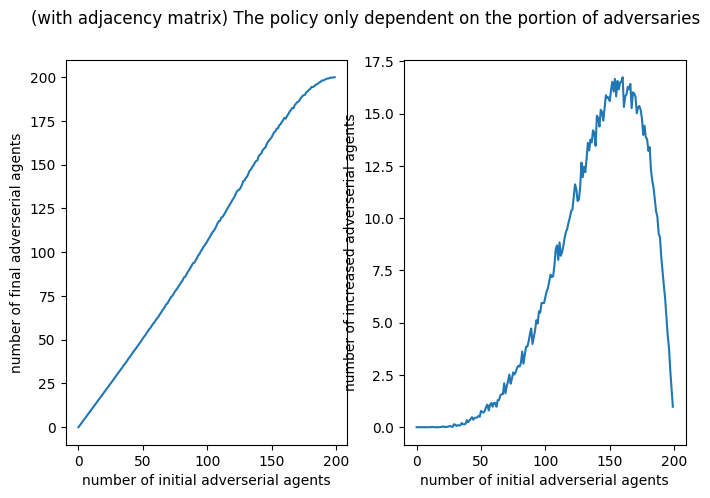

In [14]:
# time step iteration simulation begins
random.seed(random_seed)
depends_on_past_states = True # if the agent's policy depends on past states or current states?

num_purple_time = []
nums = []
num_increase_time = []

for num_adv in range(num_agents):
    initial_states = generate_states(num_agents=num_agents, num_purple=num_adv) # initial states: i purples, which means i adversaries
    prev_states = initial_states
    
    num_purple = [] # how many purple we end up wit
    num_portion = []
    num_increase = []
    
    for time in range(time_steps):
        # simulate for 10 times
        current_states_carlo = []
        current_purple_carlo = 0
        for iter in range(monte_carlo): 
            current_states, current_purple, increased_purple = simulation(num_agents=num_agents, depends_on_past_states=True,past_states=prev_states,
                                                                        func=None, impacted_by_portion=True, confidence=None, impact_from_others=adjacency, cost_of_state=None)
            if iter == 0:
                current_states_carlo =  np.copy(current_states)
            else:
                current_states_carlo = current_states_carlo + current_states
            current_states_carlo = np.array(current_states_carlo)
            current_purple_carlo += current_purple
            
        current_states = [round(num) for num in current_states_carlo/monte_carlo] # make sure the states are binary

        current_purple = current_purple_carlo/monte_carlo
        increased_purple = current_purple - num_adv
            
        num_purple.append(current_purple)
        
        num_increase.append(increased_purple)

        prev_states = current_states
    
    nums.append(num_adv)
    num_purple_time.append(num_purple)
    num_increase_time.append(num_increase)
 
num_purple_time = np.array(num_purple_time)
num_increase_time = np.array(num_increase_time)
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 0])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 0])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')


In [15]:
print(num_purple_time.shape)
print(num_increase_time.shape)

(200, 100)
(200, 100)


Text(0.5, 0.98, 'The policy only dependent on the portion of adversaries')

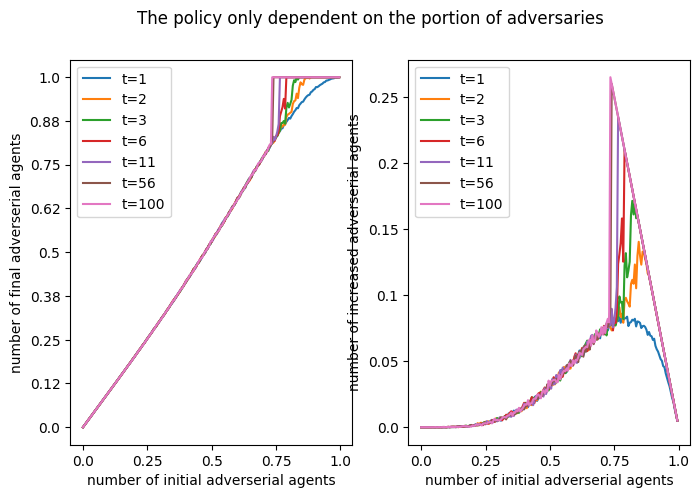

In [19]:
plt.subplots(1, 2, figsize=(8, 5))
legends = []
times_to_plot = [0, 1, 2, 5, 10, 55, 99]

ax = plt.subplot(1,2,1)
for time in range(time_steps):
    if time in times_to_plot:
        plt.plot(nums, num_purple_time[:, time])
        legend = 't='+ str(time+1)
        legends.append(legend)
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")
plt.legend(legends)
y_values = np.arange(0, 250, 50)
y_labels = np.arange(0, 250/200, 50/200)
plt.xticks(y_values, y_labels)
x_values = np.arange(0, 225, 25)
x_labels = np.around(np.arange(0, 225/200, 25/200), decimals=2)
plt.yticks(x_values, x_labels)

ax = plt.subplot(1,2,2)
for time in range(time_steps):
    if time in times_to_plot:
        plt.plot(nums, num_increase_time[:, time])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")
plt.legend(legends)
y_values = np.arange(0, 60, 10)
y_labels = np.around(np.arange(0, 60/200, 10/200), decimals=2)
plt.yticks(y_values, y_labels)
x_values = np.arange(0, 250, 50)
x_labels = np.arange(0, 250/200, 50/200)
plt.xticks(x_values, x_labels)

plt.suptitle('The policy only dependent on the portion of adversaries')